# Data Preprocessing
## Import Packages and Set Up Environment
### Import Core Packages|

In [28]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import sys
import os
from pathlib import Path
import platform
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get Current Operating System and Set Paths Dependent on Working OS

In [35]:
# Get current OS and set paths dependent on working OS.
cur_system = platform.system()
basepath = Path(os.getcwd())
cur_folder = Path(basepath).name
session_name = re.sub(r'_\d{4}-\d{2}-\d{2}_', '_', cur_folder)

print('Basepath:', basepath)
print('Working Directory:', cur_folder)
print('Session Name:', session_name)

Basepath: D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton
Working Directory: Stb_2024-10-29_Bridgehampton
Session Name: Stb_Bridgehampton


In [36]:
# Set up environment for windows
if cur_system == "Windows":
    sys.path.extend(['C:\\BrianKim\\Code\\Repositories\\NeuroPy'])  # NeuroPy Path
    save_dir = Path('D:\\Analyses\\Preprocessing')
elif cur_system == "Linux":
    save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing')
    
    # Old Code, just in case new code breaks
    #basepath = os.getcwd()

    #save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing')
    #plot_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing/Plots')
# Set Session name as folders for notebook outputs
save_dir = Path(save_dir / cur_folder)
plot_dir = Path(save_dir / 'Plots')

save_dir.mkdir(parents=True, exist_ok=True)
plot_dir.mkdir(parents=True, exist_ok=True)

print('Save Directory:', save_dir)
print('Plot Directory:', plot_dir)

Save Directory: D:\Analyses\Preprocessing\Stb_2024-10-29_Bridgehampton
Plot Directory: D:\Analyses\Preprocessing\Stb_2024-10-29_Bridgehampton\Plots


### Import NeuroPy Packages

In [37]:
# Import NeuroPy Packages
from neuropy import core
from neuropy.core import Epoch
from neuropy.core.session import ProcessData

from neuropy.analyses.artifact import detect_artifact_epochs

from neuropy.plotting.signals import plot_signal_w_epochs

from neuropy.io.openephysio import *
from neuropy.io import SpykingCircusIO

from neuropy.io.neuroscopeio import NeuroscopeIO

### Import Session Data

In [38]:
session_name = re.sub(r'_\d{4}-\d{2}-\d{2}_', '_', cur_folder)
sess = ProcessData(basepath)
print(sess.recinfo)
print(sess.eegfile)

filename: D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton\Stb_Bridgehampton.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 3534.55 seconds 
duration: 0.98 hours 



## Preprocess Ephys Data
- Identify Artifacts
    - Disconnects
    - Filtering
- Send events files to check in Neuroscope
- Write `dead_times.txt` file for spyking-circus and `artifacts.npy` files
### Identify Disconnects and Motion Artifacts

Buffer of 0.25 added before/after each epoch
D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton\Stb_Bridgehampton.art_epochs.npy saved
Artifact File: D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton\Stb_Bridgehampton.evt.art
Total artifact time = 55.3 seconds
Automatically detected artifact epochs:
       start       stop label  duration
0  3060.1260  3062.0588          1.9328
1  3075.2140  3082.2500          7.0360
2  3488.5116  3534.7996         46.2880


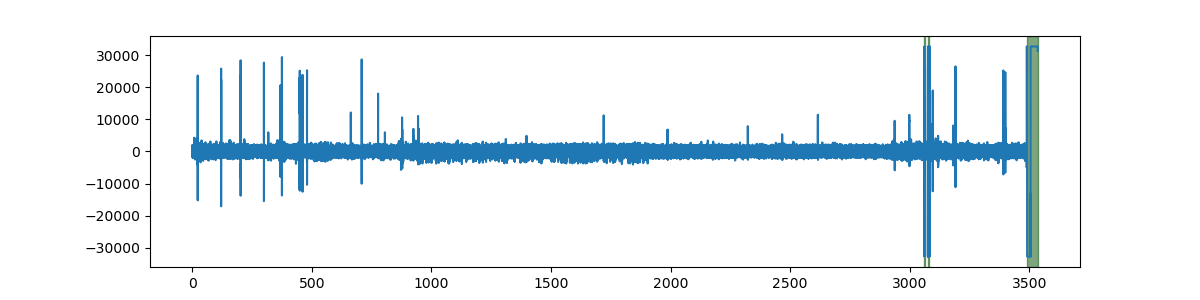

In [50]:
%matplotlib widget

# Parameters
buffer_add = 0.25    # Add buffer before and after detected artifact epochs, None = don't add any
art_thresh = 5     # Artifact detection threshold
art_edge_cutoff = 2  # Edge cutoff value
art_merge = 6        # Merges epochs that are too close to each other

# Plot Parameters
chan_plot = 8

# Get signal object
signal = sess.eegfile.get_signal()

# Find artifact epochs. If file exists already, load that instead of creating a new file.
art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")

art_epochs = detect_artifact_epochs(signal, thresh=art_thresh, edge_cutoff=art_edge_cutoff, merge=art_merge)

# Add in a buffer to prevent erroneous detetion of start/stop of artifact as SWRs.
if buffer_add is not None:
    art_epochs.add_epoch_buffer(buffer_add)

# Plot automatically detected epochs to see if they look good.
art_fig = plot_signal_w_epochs(signal, chan_plot, art_epochs)

# Save initial artifact file (.art and .npy)
art_epochs.save(art_epochs_file) # Save .npy
sess.recinfo.write_epochs(epochs=art_epochs, ext='art') # Save .art
ns_art_file = basepath / f"{session_name}.evt.art"
print('Artifact File:', ns_art_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
print('Automatically detected artifact epochs:')
print(art_epochs.to_dataframe())

### Check Events in Neuroscope
- Load evt.art file in Neuroscope and check if it aligns with artifacts in the signal.
- Check if there are any other artifact epochs that were missed by the automatic detection

D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton\Stb_Bridgehampton.art_epochs.npy saved
Total artifact time = 55.3 seconds
Automatically detected artifact epochs:
       start       stop label  duration
0  3060.1262  3062.0588          1.9326
1  3075.2142  3082.2502          7.0360
2  3488.5116  3534.7996         46.2880


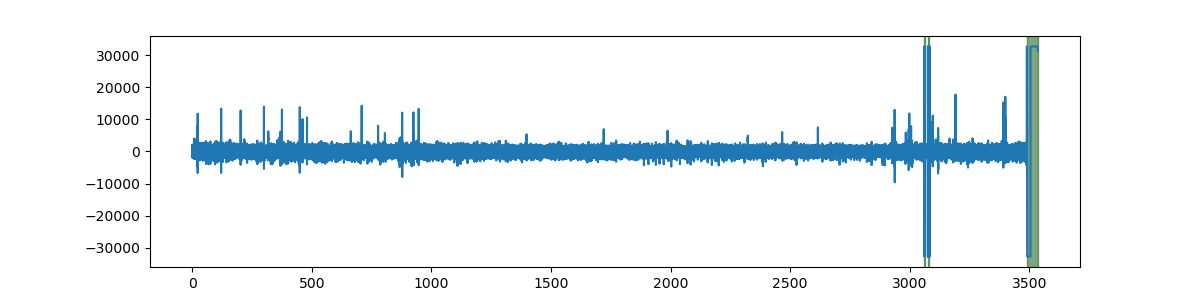

In [51]:
art_epochs = sess.recinfo.event_to_epochs(ns_art_file)
art_epochs.save(art_epochs_file)
print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
print('Automatically detected artifact epochs:')
print(art_epochs.to_dataframe())

# Plot artifact onto an example channel
chan_plot = 15 # Select a good channel
art_fig = plot_signal_w_epochs(signal, chan_plot, art_epochs)
art_fig_name = f'{session_name}_Artifacts_Channel{chan_plot}.png' 
plt.savefig(plot_dir / art_fig_name, dpi=300, bbox_inches='tight')  # Save with full path

### Identify Stimulation Epochs
- Stimulation will have artifacts that are highly stereotyped

In [53]:
SR = sess.recinfo.dat_sampling_rate

# Get sample numbers for TTL Events
ttl_events = load_all_ttl_events(sess.basepath)

stim_on_events = ttl_events.loc[ttl_events["channel_states"] == 1, "sample_number"]
stim_off_events = ttl_events.loc[ttl_events["channel_states"] == -1, "sample_number"]
stim_art_events = ttl_events.loc[ttl_events["channel_states"].abs() == 1, "sample_number"]

stim_epochs_file = sess.filePrefix.with_suffix(".stim_epochs.npy")

stim_epochs = Epoch(pd.DataFrame({
    "start": stim_on_events.reset_index(drop=True) / SR, 
    "stop": stim_off_events.reset_index(drop=True) / SR, 
    "label": ""
    }))

stim_epochs_df = stim_epochs.to_dataframe()
stim_epochs_df['time_between'] = stim_epochs_df['start'] - stim_epochs_df['stop'].shift(1)

# Rudimentary Labeling
stim_epochs = Epoch(stim_epochs_df)
sess.recinfo.write_epochs(epochs=stim_epochs, ext='stm')
stim_epochs.save(stim_epochs_file)

print(stim_epochs_df)

D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton\Stb_Bridgehampton.stim_epochs.npy saved
            start         stop label  duration  time_between
0      460.359333   460.409333        0.050000           NaN
1      503.167633   503.217633        0.050000     42.758300
2      503.255700   503.305700        0.050000      0.038067
3      503.348633   503.398633        0.050000      0.042933
4      503.459633   503.509633        0.050000      0.061000
...           ...          ...   ...       ...           ...
1457  1904.416167  1904.466167        0.050000      0.051233
1458  1904.516400  1904.566400        0.050000      0.050233
1459  1904.616700  1904.666667        0.049967      0.050300
1460  1904.717800  1904.767800        0.050000      0.051133
1461  1904.818400  1904.868400        0.050000      0.050600

[1462 rows x 5 columns]


#### Identify Stimulation Artifacts
Stimulation Artifact can currently be classified in several ways
- TTLs: Timestamps of the stim means we create a buffer around the TTL to determine the artifact.

In [54]:
buffer = 0.005
buffer_duration = 0.01

stim_art_epochs_file = sess.filePrefix.with_suffix(".stim_art_epochs.npy")

start_adjusted = pd.DataFrame({
    'start': stim_epochs_df['start'] - buffer,
    'stop': stim_epochs_df['start'] + buffer,
    'label': 0
})

stop_adjusted = pd.DataFrame({
    'start': stim_epochs_df['stop'] - buffer,
    'stop': stim_epochs_df['stop'] + buffer,
    'label': 1
})

stim_art_epochs_df = pd.concat([start_adjusted, stop_adjusted]).sort_values(by='start').reset_index(drop=True)
stim_art_epochs = Epoch(stim_art_epochs_df)
print(stim_art_epochs_df)
sess.recinfo.write_epochs(epochs=stim_art_epochs, ext='sta')
stim_art_epochs.save(stim_art_epochs_file)

            start         stop  label
0      460.354333   460.364333      0
1      460.404333   460.414333      1
2      503.162633   503.172633      0
3      503.212633   503.222633      1
4      503.250700   503.260700      0
...           ...          ...    ...
2919  1904.661667  1904.671667      1
2920  1904.712800  1904.722800      0
2921  1904.762800  1904.772800      1
2922  1904.813400  1904.823400      0
2923  1904.863400  1904.873400      1

[2924 rows x 3 columns]
D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton\Stb_Bridgehampton.stim_art_epochs.npy saved


#### Write Stim Artifact to a Trigger Detection File

In [59]:
def format_row(row):
    prefix = int(row['label'])
    start_ms = row['start'] * 1000  # Convert start time to milliseconds
    return f"{prefix} {start_ms:.6f}"

# Apply the function to each row
output = stim_art_epochs_df.apply(format_row, axis=1)

# Save to a text file without index or header
stim_times_filepath = basepath / 'spyk-circ' / 'stim_times.txt'


#stim_times_filepath = basepath + '/spyk-circ/stim_times.txt'
output.to_csv(stim_times_filepath, index=False, header=False)

### Write to Spyking-Circus `dead_times.txt` File
- Text file containing 2 columns, start and stop of artifact epochs that should be ignored by spike sorting algorithm.

In [60]:
sess.filePrefix.with_suffix(".art_epochs.npy")
SpykingCircusIO.write_epochs(sess.basepath / 'spyk-circ/dead_times.txt', art_epochs)

dead_times.txt created


In [89]:
from datetime import datetime
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

log_path = basepath / f"{session_name}_Processing_Log.txt"
log_path.parent.mkdir(parents=True, exist_ok=True)
with open(log_path, 'w') as file:
    file.write(f"Session name: {session_name}\n")
    file.write(f"Datetime: {current_datetime}\n")
    file.write(f"Working OS: {cur_system}\n")
    file.write(f"Basepath: {basepath}\n")
    file.write(f"Working Directory: {cur_folder}\n")
    file.write(f"Session Name: {session_name}\n")
    file.write(f"Save Directory: {save_dir}\n")
    file.write(f"Plot Directory: {plot_dir}\n\n")

    file.write("Artifact Detection Parameters:\n")
    file.write(f"Buffer: {buffer_add}\n")
    file.write(f"Artifact Threshold: {art_thresh}\n")
    file.write(f"Artifact Edge Cutoff: {art_edge_cutoff}\n")
    file.write(f"Artifact Merge Distance: {art_merge}\n")
    file.write(f"Stimulation Artifact Buffer: {buffer}\n")